In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For OpenCV-based face detection
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Reshape
)
from tensorflow.keras.layers import multiply

from sklearn.model_selection import train_test_split
# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Imported all relevent libraries 
# Loading face data 

#read in image data

Total faces: 182
                                                   X  Y  \
0  [185.0, 184.0, 185.0, 185.0, 186.0, 186.0, 187...  0   
1  [11.0, 15.0, 12.0, 11.0, 9.0, 10.0, 10.0, 10.0...  0   
2  [89.0, 76.0, 47.0, 50.0, 60.0, 59.0, 38.0, 26....  0   
3  [21.0, 18.0, 20.0, 21.0, 15.0, 13.0, 14.0, 13....  0   
4  [164.0, 165.0, 171.0, 167.0, 113.0, 25.0, 23.0...  0   

                                                 raw  
0  [[185, 184, 185, 185, 186, 186, 187, 187, 186,...  
1  [[11, 15, 12, 11, 9, 10, 10, 10, 12, 11, 16, 1...  
2  [[89, 76, 47, 50, 60, 59, 38, 26, 30, 44, 36, ...  
3  [[21, 18, 20, 21, 15, 13, 14, 13, 15, 18, 14, ...  
4  [[164, 165, 171, 167, 113, 25, 23, 26, 15, 15,...  


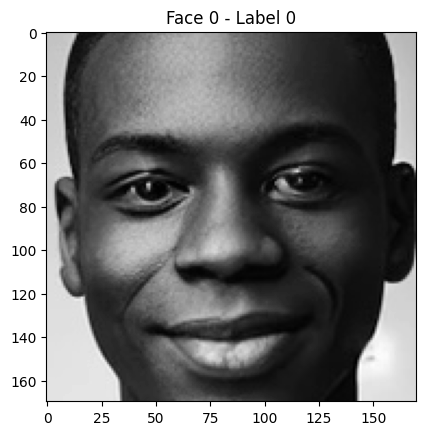

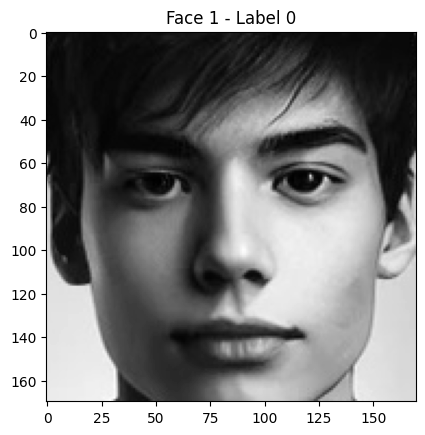

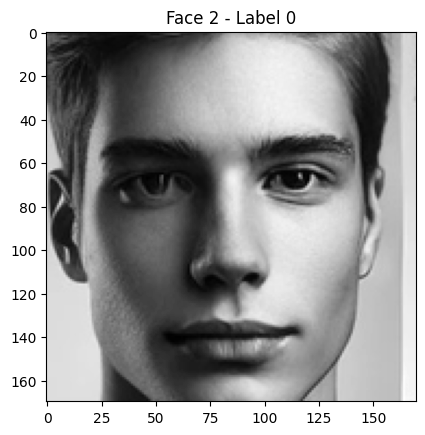

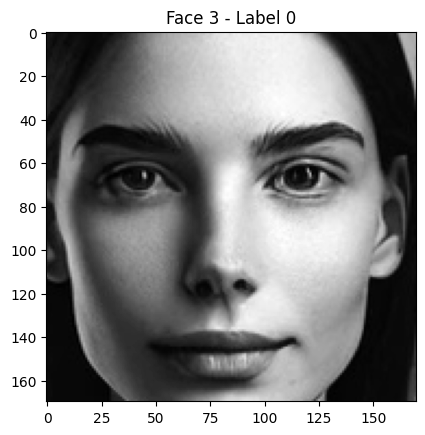

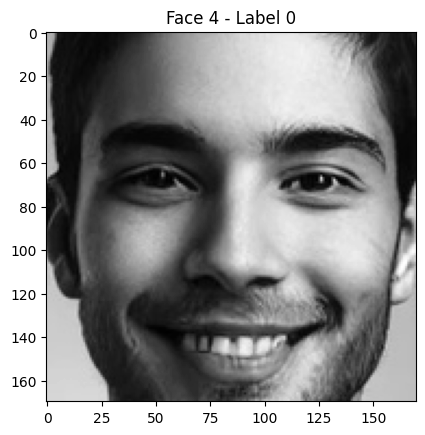

In [2]:
# Path to your Haar Cascade XML file
HAAR_CASCADE_PATH = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)

# Check if cascade loaded correctly
if face_cascade.empty():
    raise IOError(f"Could not load Haar cascade from {HAAR_CASCADE_PATH}")

def detect_faces(pil_image):
    """
    Detect faces using Haar Cascade. Return a list of PIL Images for each face.
    """
    # Convert PIL -> OpenCV format (BGR)
    open_cv_image = np.array(pil_image.convert('RGB'))[:, :, ::-1]
    
    # Convert to grayscale for detection
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Detect face bounding boxes
    faces_bboxes = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    face_images = []
    for (x, y, w, h) in faces_bboxes:
        # Crop the face region
        face_bgr = open_cv_image[y:y+h, x:x+w]
        # Convert back to PIL in 'RGB'
        face_pil = Image.fromarray(face_bgr[:, :, ::-1], mode='RGB')
        
        # OPTIONAL: Resize or center-crop to a fixed 170×170
        face_pil = face_pil.resize((170, 170), Image.Resampling.LANCZOS)
        
        face_images.append(face_pil)

    return face_images

def process_directory(directory):
    """
    Reads images from 'directory' whose filenames start with 's' or 'us'.
    's' => label=1 (squint), 'us' => label=0 (not squint).
    
    For each face in each image:
      1. Convert to 170×170 (already done in detect_faces with resize).
      2. Convert to grayscale.
      3. Store the 2D array in 'raw'.
      4. Flatten and store in 'X'.
      5. Store label in 'Y'.
    
    Then zero-pad 'X' to ensure consistent vector length for all faces.
    Returns a dict with keys: ['X', 'Y', 'raw'].
    """
    total_data = {
        'X': [],    # flattened grayscale arrays
        'Y': [],    # integer labels
        'raw': []   # unflattened 2D arrays
    }

    for filename in os.listdir(directory):
        # Skip hidden/system files
        if filename.startswith('.'):
            continue
        
        # Label logic
        if filename.startswith('s'):
            label = 1  # Squint
        elif filename.startswith('us'):
            label = 0  # Not squint
        else:
            continue
        
        full_path = os.path.join(directory, filename)
        
        try:
            # Open the image (PIL)
            img = Image.open(full_path)
            
            # Detect all faces
            faces = detect_faces(img)
            
            if len(faces) == 0:
                print(f"No faces detected in {filename}.")
                continue
            
            for face in faces:
                # Convert to grayscale
                face_gray = face.convert('L')
                
                # Convert to numpy (2D)
                face_raw = np.array(face_gray)
                
                # Store the 2D array
                total_data['raw'].append(face_raw)
                
                # Flatten to 1D
                face_flattened = face_raw.flatten()
                total_data['X'].append(face_flattened)
                
                # Store label
                total_data['Y'].append(label)
        
        except IOError:
            print(f"Cannot open image file: {filename}")

    # If no faces
    if not total_data['X']:
        print("No valid images or faces found in directory.")
        return total_data

    # Pad flattened arrays to same length
    max_len = max(len(x) for x in total_data['X'])
    X_padded = [np.pad(x, (0, max_len - len(x))) for x in total_data['X']]
    
    total_data['X'] = np.array(X_padded, dtype=np.float32)
    total_data['Y'] = np.array(total_data['Y'], dtype=np.int32)

    return total_data

def view_images(dict_obj, num_images):
    """
    Display up to n raw grayscale images (each 170x170).
    """
    num_to_show = min(num_images, len(dict_obj['raw']))
    for i in range(num_to_show):
        image_2d = dict_obj['raw'][i]
        plt.imshow(image_2d, cmap='gray')
        plt.title(f"Face {i} - Label {dict_obj['Y'][i]}")
        plt.show()

def load_face_data():
    # Example directory path
    directory = '/Users/loki/Desktop/worksurface/ai_lab/REPOS/vision/face-squint'
    
    dict_obj = process_directory(directory)

    if len(dict_obj['X']) > 0:
        df = pd.DataFrame({
            'X': list(dict_obj['X']),    # flattened, padded arrays
            'Y': dict_obj['Y'],          # labels
            'raw': list(dict_obj['raw']) # each is a 2D 170x170
        })
        
        print(f"Total faces: {len(df)}")
        print(df.head())
        
        # View some images
        view_images(dict_obj,5)
        return df
    else:
        print("No data to display.")
        return

faces=load_face_data()

In [3]:
faces.head()

,X,Y,raw
0,"[185.0, 184.0, 185.0, 185.0, 186.0, 186.0, 187...",0,"[[185, 184, 185, 185, 186, 186, 187, 187, 186,..."
1,"[11.0, 15.0, 12.0, 11.0, 9.0, 10.0, 10.0, 10.0...",0,"[[11, 15, 12, 11, 9, 10, 10, 10, 12, 11, 16, 1..."
2,"[89.0, 76.0, 47.0, 50.0, 60.0, 59.0, 38.0, 26....",0,"[[89, 76, 47, 50, 60, 59, 38, 26, 30, 44, 36, ..."
3,"[21.0, 18.0, 20.0, 21.0, 15.0, 13.0, 14.0, 13....",0,"[[21, 18, 20, 21, 15, 13, 14, 13, 15, 18, 14, ..."
4,"[164.0, 165.0, 171.0, 167.0, 113.0, 25.0, 23.0...",0,"[[164, 165, 171, 167, 113, 25, 23, 26, 15, 15,..."


# creating training, test and validate datasets

In [4]:
# ------------------------------------------------------------------------------------
# Below is the part where we create train, validation, and test splits from the DataFrame
# ------------------------------------------------------------------------------------

def create_splits(faces, test_ratio=0.2, val_ratio=0.1, random_seed=42):
    """
    Given a DataFrame 'faces', split into train, val, test sets.
    
    test_ratio: fraction of the data to be held out for testing
    val_ratio: fraction of the *remaining* data to be used for validation
    random_seed: for reproducibility
    """
    # 1. Split off the test set first
    df_trainval, df_test = train_test_split(
        faces,
        test_size=test_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=faces['Y']  # optional, if you want stratified splits by label
    )
    
    # 2. Of what's left (trainval), split out the validation set
    #    We want val_ratio *of the trainval set*.
    #    For example, if test_ratio=0.2, we have 80% left,
    #    we can do val_ratio=0.1 of the original => 0.1 / 0.8 = 0.125
    #    or you can interpret val_ratio as a fraction of the entire dataset.
    #    Here we'll assume val_ratio is the fraction of *the original dataset*,
    #    so we convert it to fraction of trainval via `val_ratio / (1 - test_ratio)`.
    relative_val_ratio = val_ratio / (1 - test_ratio)  # fraction of trainval
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=relative_val_ratio,
        random_state=random_seed,
        shuffle=True,
        stratify=df_trainval['Y']
    )
    
    return df_train, df_val, df_test

df_faces = faces
if not df_faces.empty:
    # Create train/val/test splits: 70% train, 10% val, 20% test (example)
    # => test_ratio=0.2, val_ratio=0.1
    # This means:
    #   test = 20% of total
    #   val = 10% of total
    #   train = 70% of total
    df_train, df_val, df_test = create_splits(df_faces, test_ratio=0.2, val_ratio=0.1)
    
    print("\nSplit sizes:")
    print("Train set:", len(df_train))
    print("Val set:", len(df_val))
    print("Test set:", len(df_test))
    
    # OPTIONAL: If you want them as arrays
    # Convert flattened features (X) to a 2D numpy array
    X_train = np.stack(df_train['X'].values)
    y_train = df_train['Y'].values
    
    X_val = np.stack(df_val['X'].values)
    y_val = df_val['Y'].values
    
    X_test = np.stack(df_test['X'].values)
    y_test = df_test['Y'].values

    X_train = X_train.reshape(-1, 170, 170, 1)
    X_val = X_val.reshape(-1, 170, 170, 1)
    X_test = X_test.reshape(-1, 170, 170, 1)

    
    # Now you have train, val, test in DataFrame form (df_train, df_val, df_test)
    # or in array form (X_train, y_train, X_val, y_val, X_test, y_test).
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape:   {X_val.shape},   y_val shape:   {y_val.shape}")
    print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")
else:
    print("No faces found. Exiting.")
      


Split sizes:
Train set: 126
Val set: 19
Test set: 37
X_train shape: (126, 170, 170, 1), y_train shape: (126,)
X_val shape:   (19, 170, 170, 1),   y_val shape:   (19,)
X_test shape:  (37, 170, 170, 1),  y_test shape:  (37,)


# setting up the model, training the model, and evaluating it


In [ ]:

def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excitation block."""
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', use_bias=False)(se)
    return multiply([input_tensor, se])

def create_model_with_attention(input_shape, num_classes):
    # Define input
    inputs = tf.keras.Input(shape=input_shape)

    # Conv block 1
    x = Conv2D(32, (3,3), activation='relu', padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)   # Directly call the SE function
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Conv block 2
    x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x) 
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # Classifier
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_model(input_shape, num_classes):
    """
    Builds a CNN for face classification.
    
    Args:
        input_shape (tuple): Shape of a single input image, e.g. (170, 170, 1) for grayscale
        num_classes (int): Number of output classes (e.g., 2 if squint vs. not squint)

    Returns:
        A compiled Keras model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

def train_model(model, X_train, y_train, validation_data=None, epochs=20):
    """
    Trains the CNN model using X_train, y_train, and optionally validation_data=(X_val, y_val).
    
    Args:
        model (keras.Model): Compiled Keras model.
        X_train: Training data (NumPy array or a generator-like object).
        y_train: Training labels (NumPy array). If X_train is a generator, y_train can be None.
        validation_data (tuple or generator): Either (X_val, y_val) if using NumPy arrays,
                                             or a generator-like object with 'samples' and 'batch_size'.
        epochs (int): Number of epochs to train.

    Returns:
        history: Keras History object with training curves.
    """
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

    # Figure out steps_per_epoch if X_train is a generator-like object
    if hasattr(X_train, 'samples') and hasattr(X_train, 'batch_size'):
        steps_per_epoch = X_train.samples // X_train.batch_size
    else:
        steps_per_epoch = None

    # Figure out validation_steps if validation_data is also a generator
    validation_steps = None
    if validation_data is not None:
        if hasattr(validation_data, 'samples') and hasattr(validation_data, 'batch_size'):
            validation_steps = validation_data.samples // validation_data.batch_size


    # One-hot encode the labels (which are 0 or 1)
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes=2)
    y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes=2)


    # Now fit the model
    # If X_train, y_train are NumPy arrays, this works
    # If X_train is a generator, it expects y_train=None (typical for generators),
    #   but we allow it here in case user wants to pass it anyway.
    history = model.fit(
        X_train, 
        y_train_oh, 
        validation_data=(X_val, y_val_oh),
        epochs=80
    )
    
    return history

def evaluate_model(model, test_data):
    """
    Evaluates the model on test_data and prints the loss & accuracy.
    
    Args:
        model (keras.Model): Trained Keras model.
        test_data: Test dataset (ImageDataGenerator, tf.data.Dataset, or (x_test, y_test)).
    """
    # If it's an ImageDataGenerator, we can do steps = test_data.samples // test_data.batch_size
    # If it's tf.data or NumPy arrays, you can omit steps.
    
    steps = None
    if hasattr(test_data, "samples") and hasattr(test_data, "batch_size"):
        steps = test_data.samples // test_data.batch_size
    
    scores = model.evaluate(test_data, steps=steps)
    print(f"Test Loss: {scores[0]}")
    print(f"Test Accuracy: {scores[1]}")

#
# EXAMPLE USAGE (assuming you have train_data, val_data, test_data):
#
model = create_model_with_attention(input_shape=(170,170,1), num_classes=2)



callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = train_model(model, X_train, y_train, validation_data=(X_val, y_val))
#evaluate_model(model, df_test)
#


Epoch 1/100
4/4 [==============================] - 2s 293ms/step - loss: 1.5278 - accuracy: 0.6429 - val_loss: 9.8905 - val_accuracy: 0.5789
Epoch 2/100
4/4 [==============================] - 1s 215ms/step - loss: 0.4891 - accuracy: 0.8333 - val_loss: 5.1358 - val_accuracy: 0.4737
Epoch 3/100
4/4 [==============================] - 1s 215ms/step - loss: 0.2686 - accuracy: 0.8730 - val_loss: 3.1104 - val_accuracy: 0.4737
Epoch 4/100
4/4 [==============================] - 1s 215ms/step - loss: 0.2248 - accuracy: 0.9286 - val_loss: 1.8380 - val_accuracy: 0.6316
Epoch 5/100
4/4 [==============================] - 1s 217ms/step - loss: 0.1803 - accuracy: 0.9286 - val_loss: 1.5731 - val_accuracy: 0.5789
Epoch 6/100
4/4 [==============================] - 1s 215ms/step - loss: 0.1895 - accuracy: 0.9206 - val_loss: 1.3309 - val_accuracy: 0.5789
Epoch 7/100
4/4 [==============================] - 1s 215ms/step - loss: 0.1843 - accuracy: 0.9444 - val_loss: 0.8625 - val_accuracy: 0.7895
Epoch 8/100
4

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 170, 170, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 168, 168, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 168, 168, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 global_average_pooling2d (  (None, 32)                   0         ['batch_normalization[0][0

In [7]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves
    from a Keras History object.
    """
    # Use a Seaborn style/theme for a "fancy" look
    sns.set_style("darkgrid") 

    # Extract values for accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create an array of epoch indices (1-based)
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots: Accuracy & Loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Accuracy Plot ---
    axes[0].plot(epochs, acc, label='Training Accuracy', marker='o', color='blue')
    axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orange')
    axes[0].set_title('Training & Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    
    # --- Loss Plot ---
    axes[1].plot(epochs, loss, label='Training Loss', marker='o', color='red')
    axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='green')
    axes[1].set_title('Training & Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()

    # Add a main title for the entire figure
    fig.suptitle('Model Performance Over Epochs', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

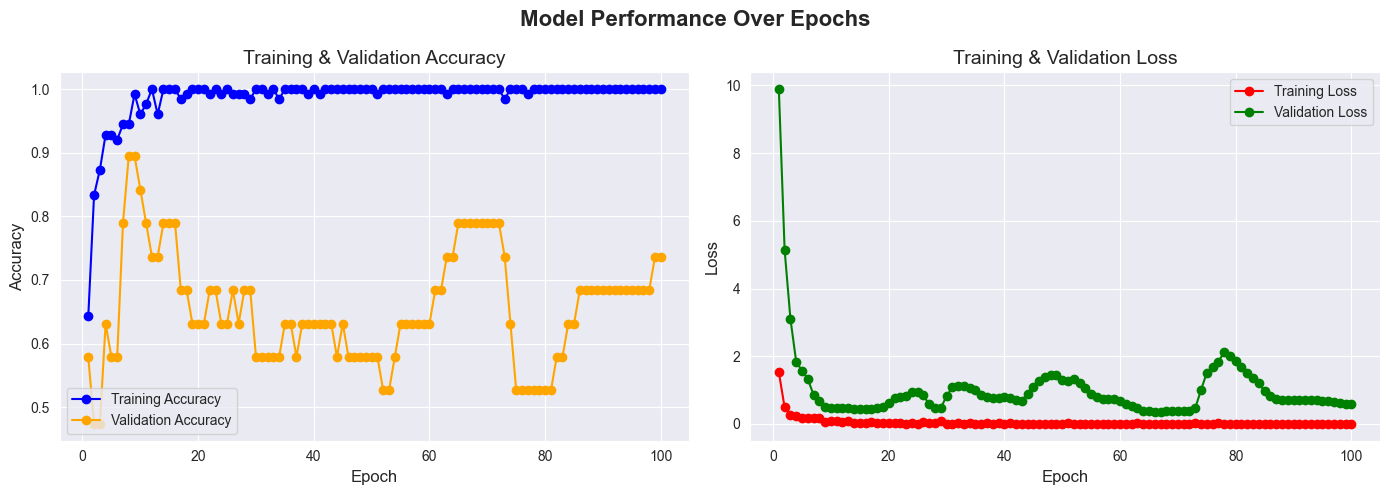

In [8]:
plot_training_history(history)